[lap-mathurin-01:714075] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.lap-mathurin-01.1000/jf.0/4137877504/shared_mem_cuda_pool.lap-mathurin-01 could be created.
[lap-mathurin-01:714075] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 


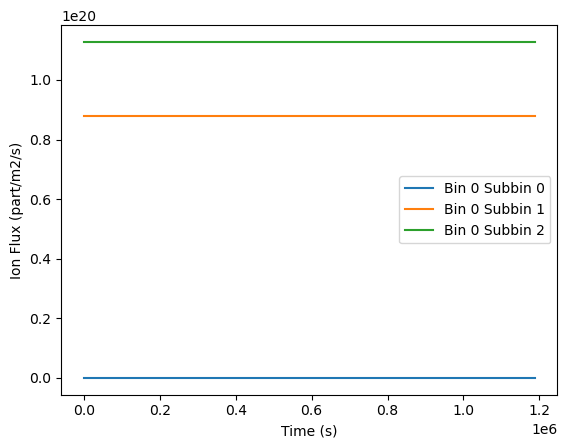

In [1]:
from iter_all_bin_scenario import plasma_data_handling, my_scenario, FW_bins

import numpy as np
import matplotlib.pyplot as plt

t = np.linspace(0, my_scenario.get_maximum_time(), 1000)
FW_bin = FW_bins.bins[0]
for i, sub_bin in enumerate(FW_bin.sub_bins):
    ion_flux = []
    for t_val in t:
        ion_flux.append(
            plasma_data_handling.get_particle_flux("FP", bin=sub_bin, t_rel=t, ion=True)
        )
    plt.plot(t, ion_flux, label=f"Bin {FW_bin.index} Subbin {i}")
plt.xlabel("Time (s)")
plt.ylabel("Ion Flux (part/m2/s)")
plt.legend()
plt.show()


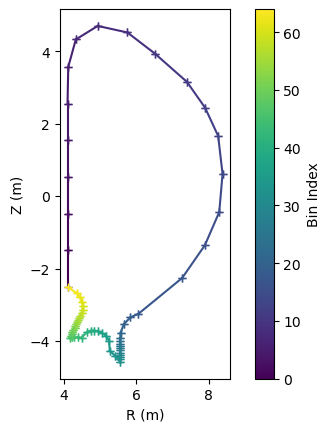

In [2]:
from make_iter_bins import my_reactor

bins = my_reactor.first_wall.bins + my_reactor.divertor.bins

norm = plt.Normalize(0, len(bins))
cmap = plt.get_cmap("viridis")

for bin in bins:
    plt.plot(
        [bin.start_point[0], bin.end_point[0]],
        [bin.start_point[1], bin.end_point[1]],
        c=cmap(norm(bin.index)),
        marker="+",
    )
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label="Bin Index", ax=plt.gca())
plt.xlabel("R (m)")
plt.ylabel("Z (m)")
plt.gca().set_aspect("equal", adjustable="box")

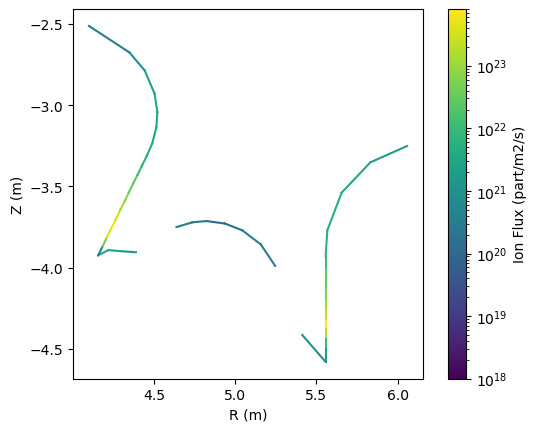

In [3]:
from make_iter_bins import my_reactor

bins = my_reactor.first_wall.bins + my_reactor.divertor.bins
ion_fluxes = []
start_points = []
end_points = []

for bin in my_reactor.divertor.bins:
    ion_fluxes.append(
        float(plasma_data_handling.get_particle_flux("FP", bin=bin, t_rel=0, ion=True))
    )
    start_points.append(bin.start_point)
    end_points.append(bin.end_point)

from matplotlib.colors import LogNorm, Normalize
norm = LogNorm(1e18, max(ion_fluxes))
cmap = plt.get_cmap("viridis")


for start_point, end_point, ion_flux in zip(start_points, end_points, ion_fluxes):
    plt.plot(
        [start_point[0], end_point[0]],
        [start_point[1], end_point[1]],
        c=cmap(norm(ion_flux)),
    )
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label="Ion Flux (part/m2/s)", ax=plt.gca())
plt.xlabel("R (m)")
plt.ylabel("Z (m)")
plt.gca().set_aspect("equal", adjustable="box")

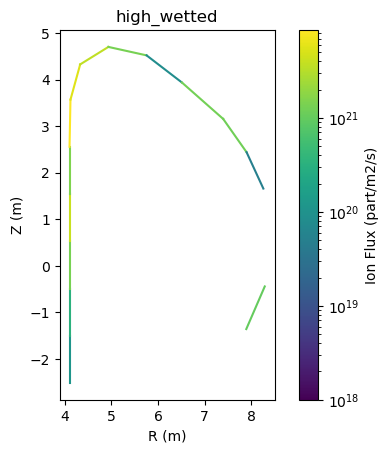

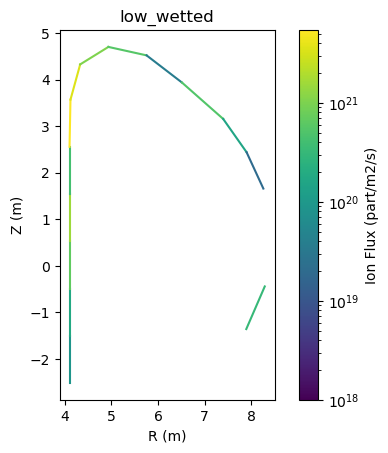

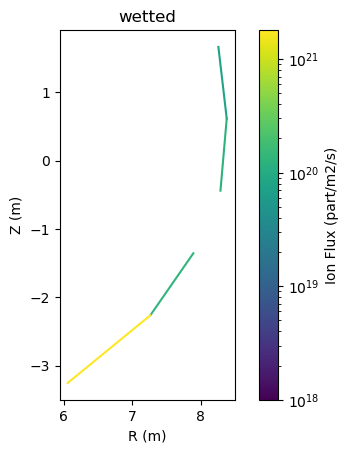

In [4]:
from make_iter_bins import my_reactor
from matplotlib.colors import LogNorm

for mode in ["high_wetted", "low_wetted", "wetted"]:
    ion_fluxes = []
    start_points = []
    end_points = []
    for bin in my_reactor.first_wall.bins:
        for sub_bin in bin.sub_bins:
            if sub_bin.mode == mode:
                ion_flux = plasma_data_handling.get_particle_flux("FP", bin=sub_bin, t_rel=0, ion=True)
                ion_fluxes.append(ion_flux)

                start_points.append(bin.start_point)
                end_points.append(bin.end_point)


    norm = LogNorm(1e18, max(ion_fluxes))
    cmap = plt.get_cmap("viridis")


    for start_point, end_point, ion_flux in zip(start_points, end_points, ion_fluxes):
        plt.plot(
            [start_point[0], end_point[0]],
            [start_point[1], end_point[1]],
            c=cmap(norm(ion_flux)),
        )
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label="Ion Flux (part/m2/s)", ax=plt.gca())
    plt.xlabel("R (m)")
    plt.ylabel("Z (m)")
    plt.gca().set_aspect("equal", adjustable="box")
    plt.title(mode)
    plt.show()

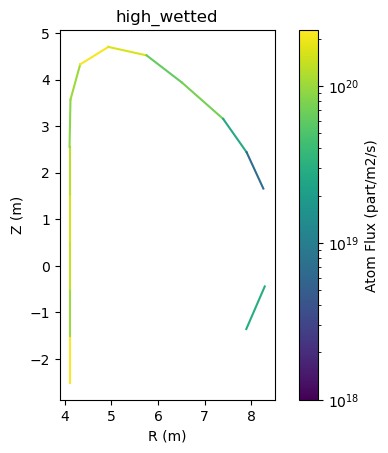

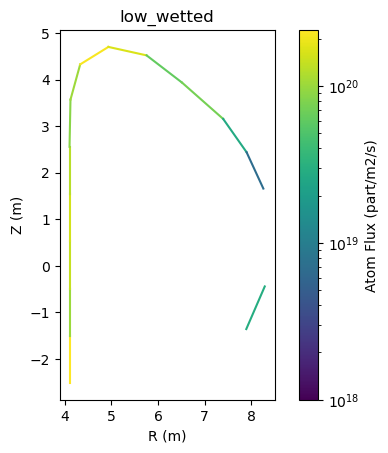

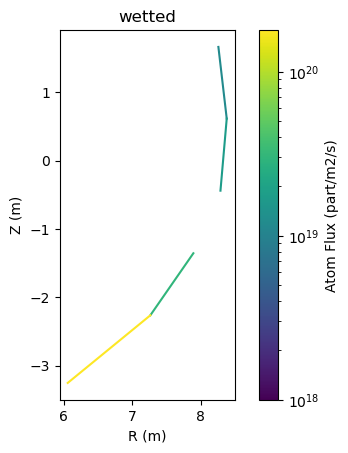

In [5]:
from make_iter_bins import my_reactor
from matplotlib.colors import LogNorm

for mode in ["high_wetted", "low_wetted", "wetted"]:
    atom_fluxes = []
    start_points = []
    end_points = []
    for bin in my_reactor.first_wall.bins:
        for sub_bin in bin.sub_bins:
            if sub_bin.mode == mode:
                atom_flux = plasma_data_handling.get_particle_flux("FP", bin=sub_bin, t_rel=0, ion=False)
                atom_fluxes.append(atom_flux)

                start_points.append(bin.start_point)
                end_points.append(bin.end_point)


    norm = LogNorm(1e18, max(atom_fluxes))
    cmap = plt.get_cmap("viridis")


    for start_point, end_point, ion_flux in zip(start_points, end_points, atom_fluxes):
        plt.plot(
            [start_point[0], end_point[0]],
            [start_point[1], end_point[1]],
            c=cmap(norm(ion_flux)),
        )
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label="Atom Flux (part/m2/s)", ax=plt.gca())
    plt.xlabel("R (m)")
    plt.ylabel("Z (m)")
    plt.gca().set_aspect("equal", adjustable="box")
    plt.title(mode)
    plt.show()

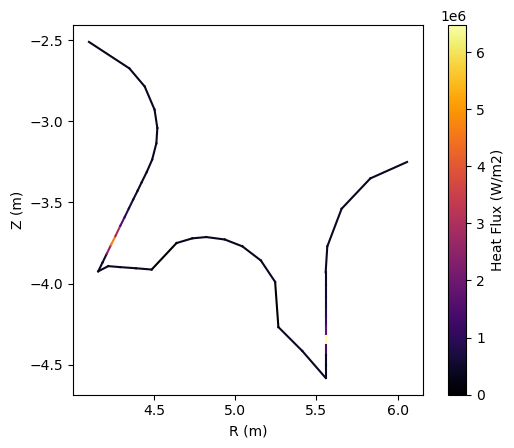

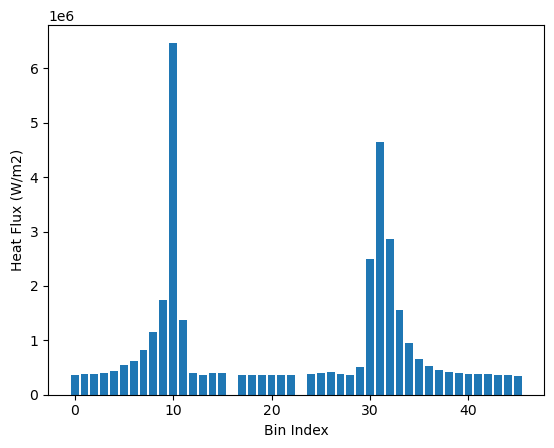

In [6]:
from make_iter_bins import my_reactor

heat_fluxes = []
start_points = []
end_points = []
for bin in my_reactor.divertor.bins:
    heat_flux = plasma_data_handling.get_heat("FP", bin=bin, t_rel=0)
    heat_fluxes.append(heat_flux)

    start_points.append(bin.start_point)
    end_points.append(bin.end_point)


norm = Normalize(0, max(heat_fluxes))
cmap = plt.get_cmap("inferno")


for start_point, end_point, heat_flux in zip(start_points, end_points, heat_fluxes):
    plt.plot(
        [start_point[0], end_point[0]],
        [start_point[1], end_point[1]],
        c=cmap(norm(heat_flux)),
    )
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label="Heat Flux (W/m2)", ax=plt.gca())
plt.xlabel("R (m)")
plt.ylabel("Z (m)")
plt.gca().set_aspect("equal", adjustable="box")
plt.show()

plt.bar(range(len(heat_fluxes)), heat_fluxes)
plt.xlabel("Bin Index")
plt.ylabel("Heat Flux (W/m2)")
plt.show()

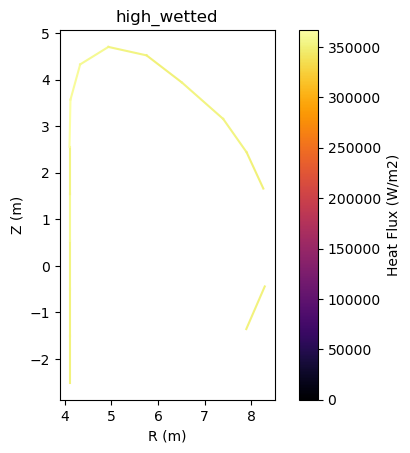

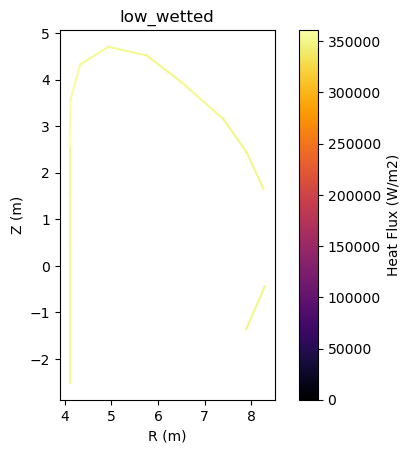

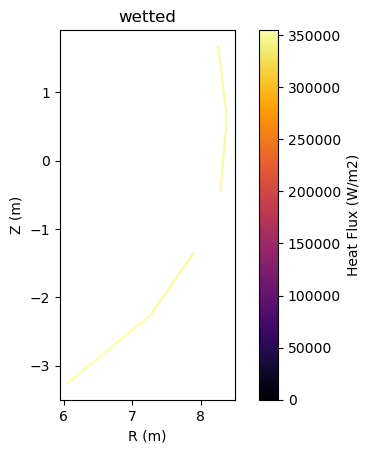

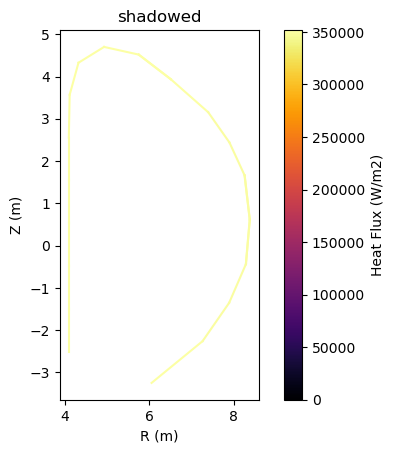

In [8]:
for mode in ["high_wetted", "low_wetted", "wetted", "shadowed"]:
    heat_fluxes = []
    start_points = []
    end_points = []
    for bin in my_reactor.first_wall.bins:
        for sub_bin in bin.sub_bins:
            if sub_bin.mode == mode:
                heat_flux = plasma_data_handling.get_heat("FP", bin=sub_bin, t_rel=0)
                heat_fluxes.append(heat_flux)

                start_points.append(bin.start_point)
                end_points.append(bin.end_point)


    norm = Normalize(0, max(heat_fluxes))
    cmap = plt.get_cmap("inferno")


    for start_point, end_point, heat_flux in zip(start_points, end_points, heat_fluxes):
        plt.plot(
            [start_point[0], end_point[0]],
            [start_point[1], end_point[1]],
            c=cmap(norm(heat_flux)),
        )
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label="Heat Flux (W/m2)", ax=plt.gca())
    plt.xlabel("R (m)")
    plt.ylabel("Z (m)")
    plt.gca().set_aspect("equal", adjustable="box")
    plt.title(mode)
    plt.show()